In [125]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import matplotlib
import csv
from numpy.linalg import inv
import open3d as o3d
import pickle
from tqdm import tqdm
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
from utils.pcd_utils import _align_rgb_depth
from multiprocessing import Pool


from utils.depth_metrics import compute_valid_depth_mask
from utils.pcd_utils import smooth_depth
import utils.depth_calib_utils as utils

matplotlib.rcParams['figure.figsize'] = (20, 10)

In [126]:
def eval_add_to_dict(depthGT_, depth_pred_, method, eval_range, low, high, errs_all):
    depth_pred = depth_pred_.copy()
    
    depth_pred[depth_pred_ < low] = 0
    depth_pred[depth_pred_ > high] = 0
    depth_pred = cv2.resize(depth_pred, (640, 360))

    depth_pred = smooth_depth(depth_pred)


    depth_gt = smooth_depth(depthGT_.copy())
    depth_gt = cv2.resize(depth_gt, (depth_pred.shape[1], depth_pred.shape[0]))
#     depth_gt[depthGT_ > high] = 0
#     depth_gt[depthGT_ < low] = 0

    valid_mask = compute_valid_depth_mask(depth_pred, depth_gt)
    plt.figure(figsize = (500, 10))
    tmp = np.zeros(depth_pred.shape)
    tmp[valid_mask] = depth_pred[valid_mask]
    plt.imshow(tmp, cmap="hsv")
    plt.colorbar()

    plt.show()
    errs, errs_scaled, scale = evaluate_depth(depth_gt, depth_pred, inverse_gt=False, inverse_pred=False)
    print(f'{method} scale {scale} at range {eval_range}')
    if not np.isnan(errs['rmse']):
        if not method in errs_all[eval_range]:
            errs_all[eval_range][method] = {'errs': [], 'errs_scaled': [], 'scale': []}

        errs_all[eval_range][method]['errs'].append(errs)
        errs_all[eval_range][method]['errs_scaled'].append(errs_scaled)
        errs_all[eval_range][method]['scale'].append(scale)

    return errs_all

# errs_elas, errs_pred_scaled_elas, scale_elas = evaluate_depth(depthGT, depthELAS, inverse_gt=False, inverse_pred=False)
# print(f'ELAS scale {scale_elas}')
# errs_scaled_elas_all.append(errs_pred_scaled_elas)
# errs_elas_all.append(errs_elas)
# scales_elas.append(scale_elas)

# errs_ar, errs_pred_scaled_ar, scale_ar = evaluate_depth(depthGT_unaligned, depthMap, inverse_gt=False, inverse_pred=False)
# print(f'Arcore scale {scale_ar}')
# errs_scaled_arcore_all.append(errs_pred_scaled_ar)
# errs_arcore_all.append(errs_ar)
# scales_arcore.append(scale_ar)

In [153]:
with_arcore = False

## Load calibration parameters

In [154]:
if with_arcore:
    w = 640
    h = 360
    x = 0
    y = 60
    scaling = 1/3
else:
    w = 1920
    h = 1080
    x = 0
    y = 0
    scaling = 1

In [155]:
Left_Stereo_Map, Right_Stereo_Map, extrinsics, intrinsics_l, intrinsics_r = utils.load_calibration_params((w, h), scaling)

In [156]:
T1 = np.zeros((4,4))
T1[:3, :3] = extrinsics['rect_l']
T1[3, 3] = 1
T1[:3,3] = [0, 0, 0] 
undist_mtx = extrinsics['proj_mat_l'][:3,:3]
distL = extrinsics['distL']

undist_mtx_original = intrinsics_l['mtx'] * scaling
undist_mtx_original[2,2] = 1
undist_mtx_original

undist_mtx

array([[1.44957905e+03, 0.00000000e+00, 9.78359161e+02],
       [0.00000000e+00, 1.44957905e+03, 5.21515831e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [157]:
intrinsics = undist_mtx_original

from open3d import camera
intr = camera.PinholeCameraIntrinsic(640, 360, intrinsics[0,0], intrinsics[1,1], intrinsics[0, 2], intrinsics[1,2])

# import open3d as o3d
# o3d.io.write_pinhole_camera_intrinsic('/media/pc/Data/test_ar/intrinsic.json', intr)

## Load preliminary data

In [158]:
from utils.depth_metrics import evaluate_depth

In [159]:
import subprocess
import scipy.ndimage

In [161]:
# load association
VID = '/2022-01-27-15-10-42'
path = f"/media/pc/Data/bag-extractor/output/{VID}/smartphone_video_frames"
gt_path = f"/media/pc/Data/bag-extractor/output/{VID}/depth"
gt_unaligned_path = f"/media/pc/Data/bag-extractor/output/{VID}/depth_unaligned"

with open(f'/media/pc/Data/bag-extractor/output/{VID}/association.txt') as file:
    association = np.genfromtxt(file,dtype='str')
print(association)

print('2696.343485285' in association)

association = {row[0]:row[1:] for row in association}

left_dir_name = 'left'


[['2696.343485285' 'rgb/2696.343485285.png' '2696.363055246'
  'depth/2696.363055246.png']
 ['2697.743264977' 'rgb/2697.743264977.png' '2697.76345179'
  'depth/2697.76345179.png']
 ['2699.343001245' 'rgb/2699.343001245.png' '2699.363401358'
  'depth/2699.363401358.png']
 ['2700.742779667' 'rgb/2700.742779667.png' '2700.763488398'
  'depth/2700.763488398.png']
 ['2701.542651358' 'rgb/2701.542651358.png' '2701.56340955'
  'depth/2701.56340955.png']
 ['2702.742456319' 'rgb/2702.742456319.png' '2702.76318171'
  'depth/2702.76318171.png']
 ['2703.942264895' 'rgb/2703.942264895.png' '2703.963023502'
  'depth/2703.963023502.png']
 ['2706.341884817' 'rgb/2706.341884817.png' '2706.362814606'
  'depth/2706.362814606.png']
 ['2707.541688816' 'rgb/2707.541688816.png' '2707.562642062'
  'depth/2707.562642062.png']
 ['2708.541527853' 'rgb/2708.541527853.png' '2708.562478734'
  'depth/2708.562478734.png']
 ['2709.341401084' 'rgb/2709.341401084.png' '2709.36239195'
  'depth/2709.36239195.png']
 ['2710

In [162]:
if with_arcore: 
    arcore_ts = []
    for file in glob.glob(f'{path}/{left_dir_name}/*.txt'):
        print(os.path.basename(file))     

        name = int(os.path.basename(file).split('.')[0])
        print(name)
        arcore_ts.append(name)

    arcore_ts

In [163]:
def depth_from_disp(disp, Q):
    img_3d = cv2.reprojectImageTo3D(disp, Q, handleMissingValues = 0)
    tmp_depth = img_3d[:,:,2]
    tmp_depth[tmp_depth < 0] = 0
#     depth[depth > 8] = 0

    return tmp_depth

In [164]:
Q = extrinsics['Q']

extrinsics

{'Q': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -9.78359161e+02],
        [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         -5.21515831e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.44957905e+03],
        [ 0.00000000e+00,  0.00000000e+00,  7.19065313e+00,
         -0.00000000e+00]]),
 'rect_l': array([[ 0.99962275,  0.02562861, -0.00987556],
        [-0.02575785,  0.9995812 , -0.01318935],
        [ 0.0095334 ,  0.01343875,  0.99986425]]),
 'distL': array([[ 0.03220824,  0.04381164, -0.00159229, -0.00076361, -0.12319342]]),
 'proj_mat_l': array([[1.44957905e+03, 0.00000000e+00, 9.78359161e+02, 0.00000000e+00],
        [0.00000000e+00, 1.44957905e+03, 5.21515831e+02, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00]]),
 'new_mtxL': array([[1.44763523e+03, 0.00000000e+00, 9.60421778e+02],
        [0.00000000e+00, 1.45261291e+03, 5.21425549e+02],
        [0.00000000e+00, 0.0000000

In [165]:
intrinsics_r

{'mtx': array([[1.44202140e+03, 0.00000000e+00, 9.56108708e+02],
        [0.00000000e+00, 1.44654519e+03, 5.26037648e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[ 0.04338731,  0.05211754, -0.00141933, -0.00033987, -0.18603325]]),
 'rvecs': array([[[ 0.16525937],
         [-0.5339423 ],
         [-1.3741718 ]],
 
        [[ 0.11542016],
         [-0.49535967],
         [-1.34611604]],
 
        [[ 0.03159014],
         [-0.29723733],
         [-1.11057979]],
 
        [[ 0.11155681],
         [-0.2682469 ],
         [-1.24980579]],
 
        [[ 0.13073715],
         [-0.28141982],
         [-1.2595048 ]],
 
        [[ 0.20357443],
         [-0.38541739],
         [-1.29676718]],
 
        [[-0.15395002],
         [-0.52759359],
         [-0.93162855]],
 
        [[-0.18915702],
         [-0.13717179],
         [ 1.54682299]],
 
        [[-0.21365546],
         [-0.06334834],
         [ 1.52998992]],
 
        [[-0.21220349],
         [-0.03858558],


In [166]:
intrinsics_l

{'mtx': array([[1.44763523e+03, 0.00000000e+00, 9.60421778e+02],
        [0.00000000e+00, 1.45261291e+03, 5.21425549e+02],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 'dist': array([[ 0.03220824,  0.04381164, -0.00159229, -0.00076361, -0.12319342]]),
 'rvecs': array([[[ 0.14841015],
         [-0.55130555],
         [-1.35059044]],
 
        [[ 0.0970165 ],
         [-0.51093949],
         [-1.32320029]],
 
        [[ 0.01386995],
         [-0.30811405],
         [-1.09022751]],
 
        [[ 0.09259088],
         [-0.28688782],
         [-1.23007556]],
 
        [[ 0.11194126],
         [-0.30039835],
         [-1.23953826]],
 
        [[ 0.18473494],
         [-0.40188   ],
         [-1.27498127]],
 
        [[-0.1721506 ],
         [-0.54257689],
         [-0.90956682]],
 
        [[-0.21131543],
         [-0.11837769],
         [ 1.56527621]],
 
        [[-0.23573607],
         [-0.04387947],
         [ 1.54757056]],
 
        [[-0.23601126],
         [-0.01710133],


## Running metrics

In [167]:
errs_all = {'0-2m': {}, '2-4m': {}, 'all': {}}

In [168]:



def read_rotate(path, bw):
    if (bw == 0):
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path, 1)


    return cv2.rotate(img, cv2.ROTATE_180)

/media/pc/Data/bag-extractor/output//2022-01-27-15-10-42/smartphone_video_frames/left/2719339795192.png
/media/pc/Data/bag-extractor/output//2022-01-27-15-10-42/smartphone_video_frames/right/2719339822134.png


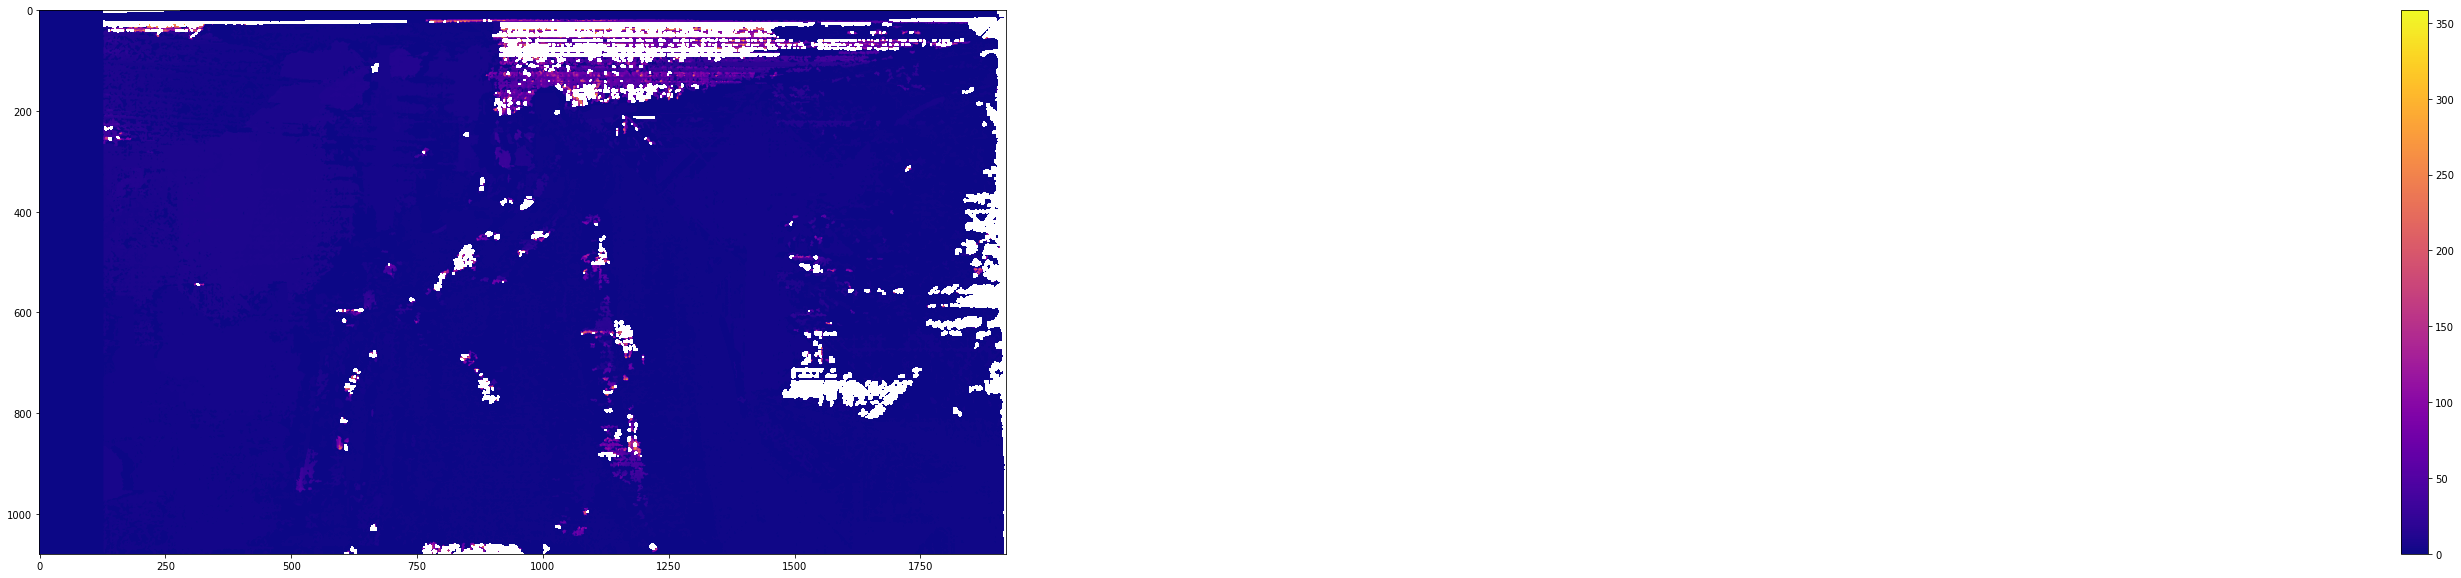

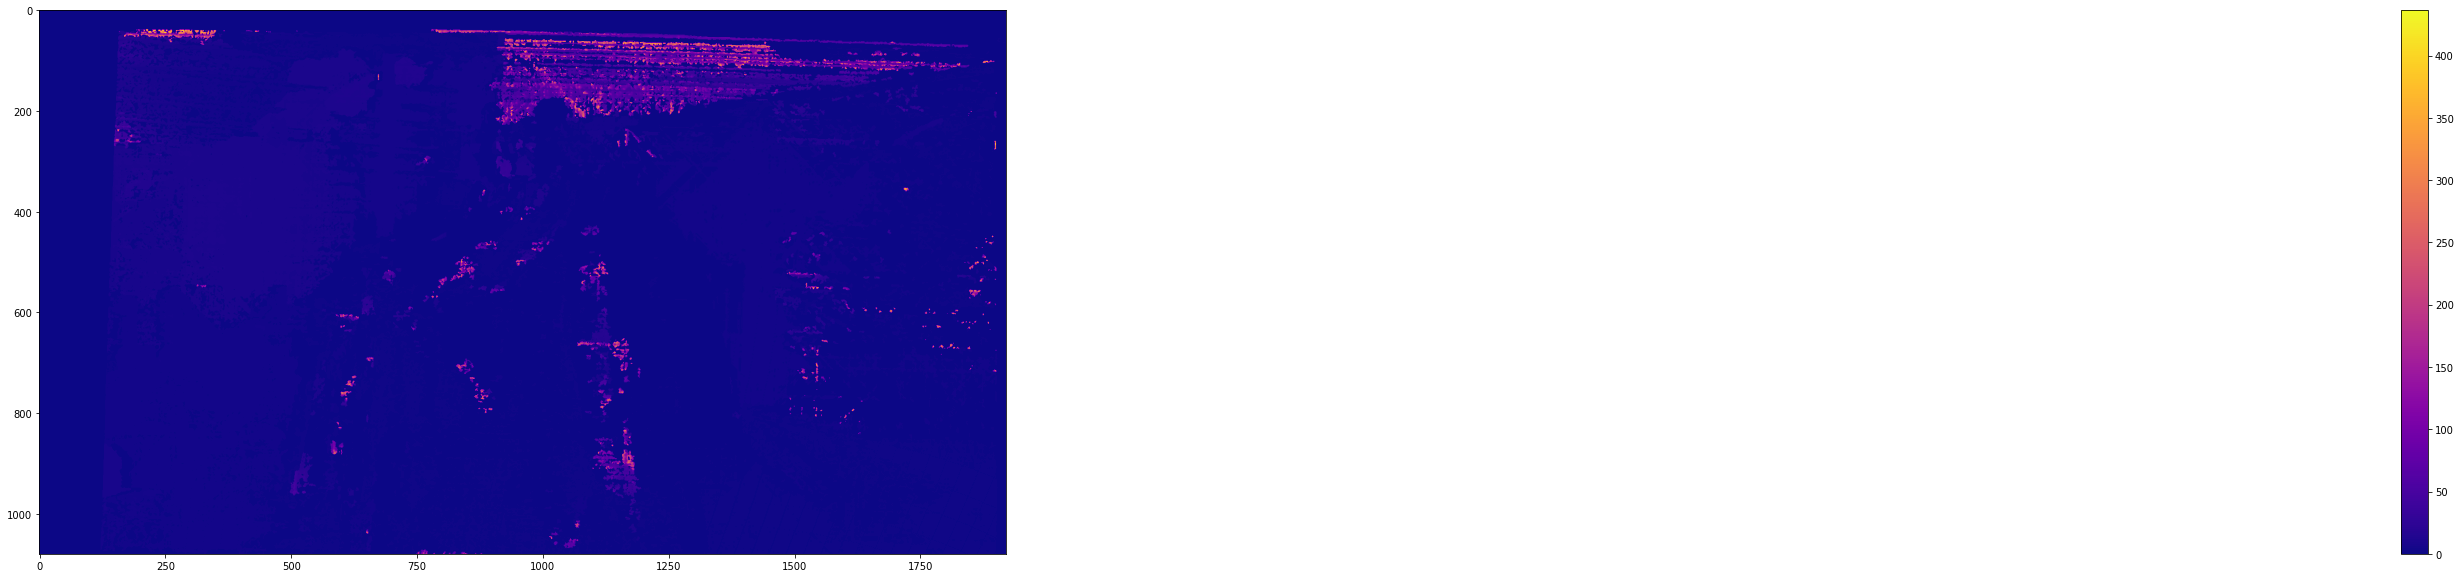

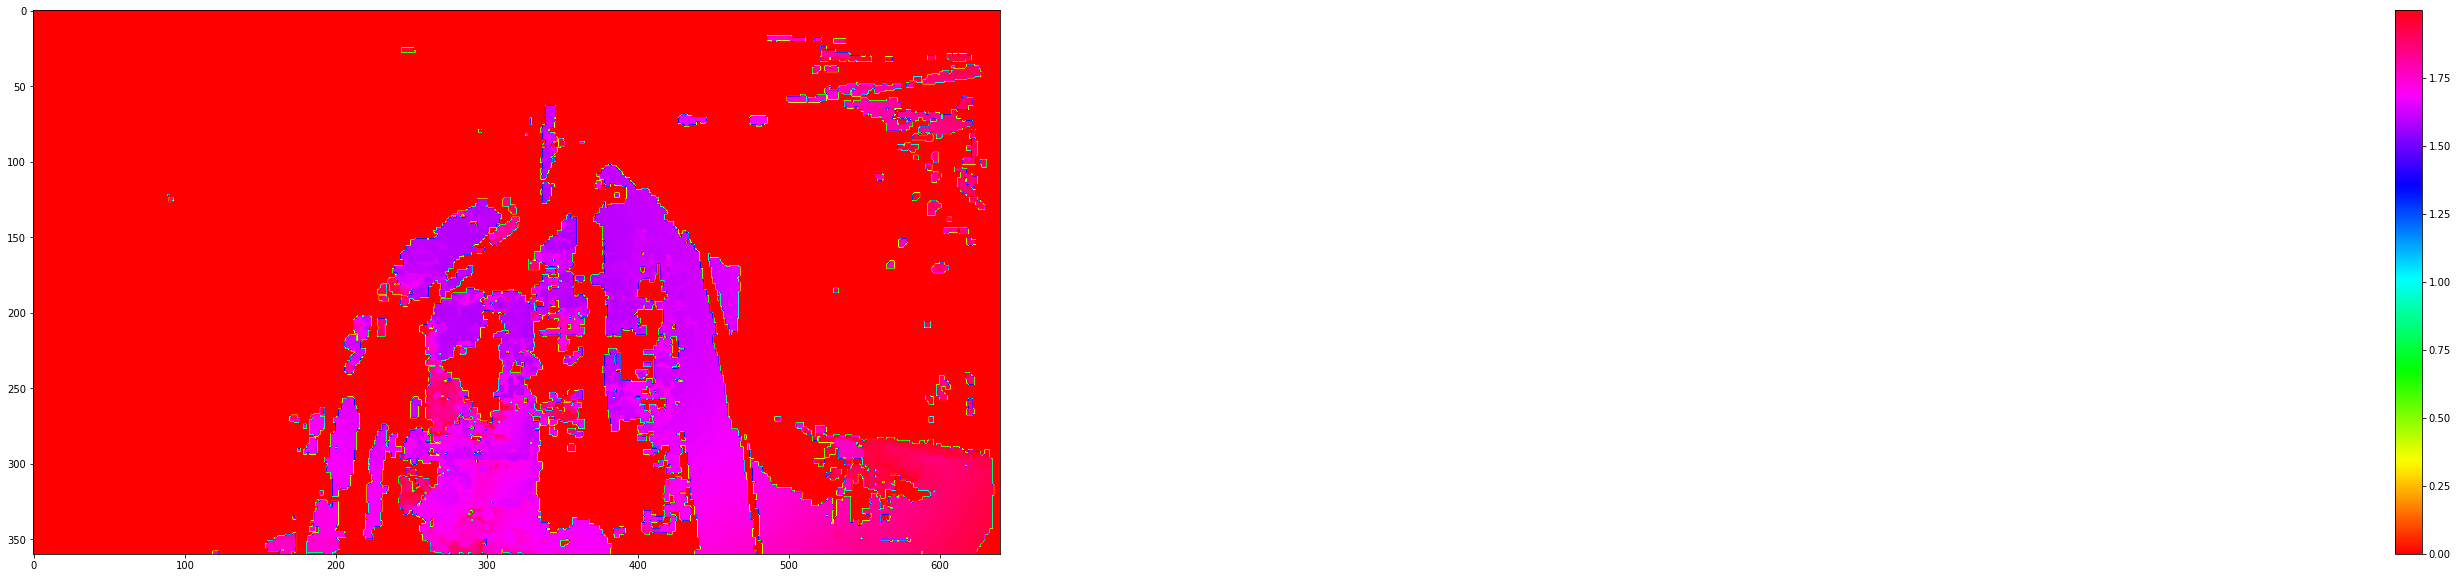

sgbm scale 0.897743807447123 at range 0-2m


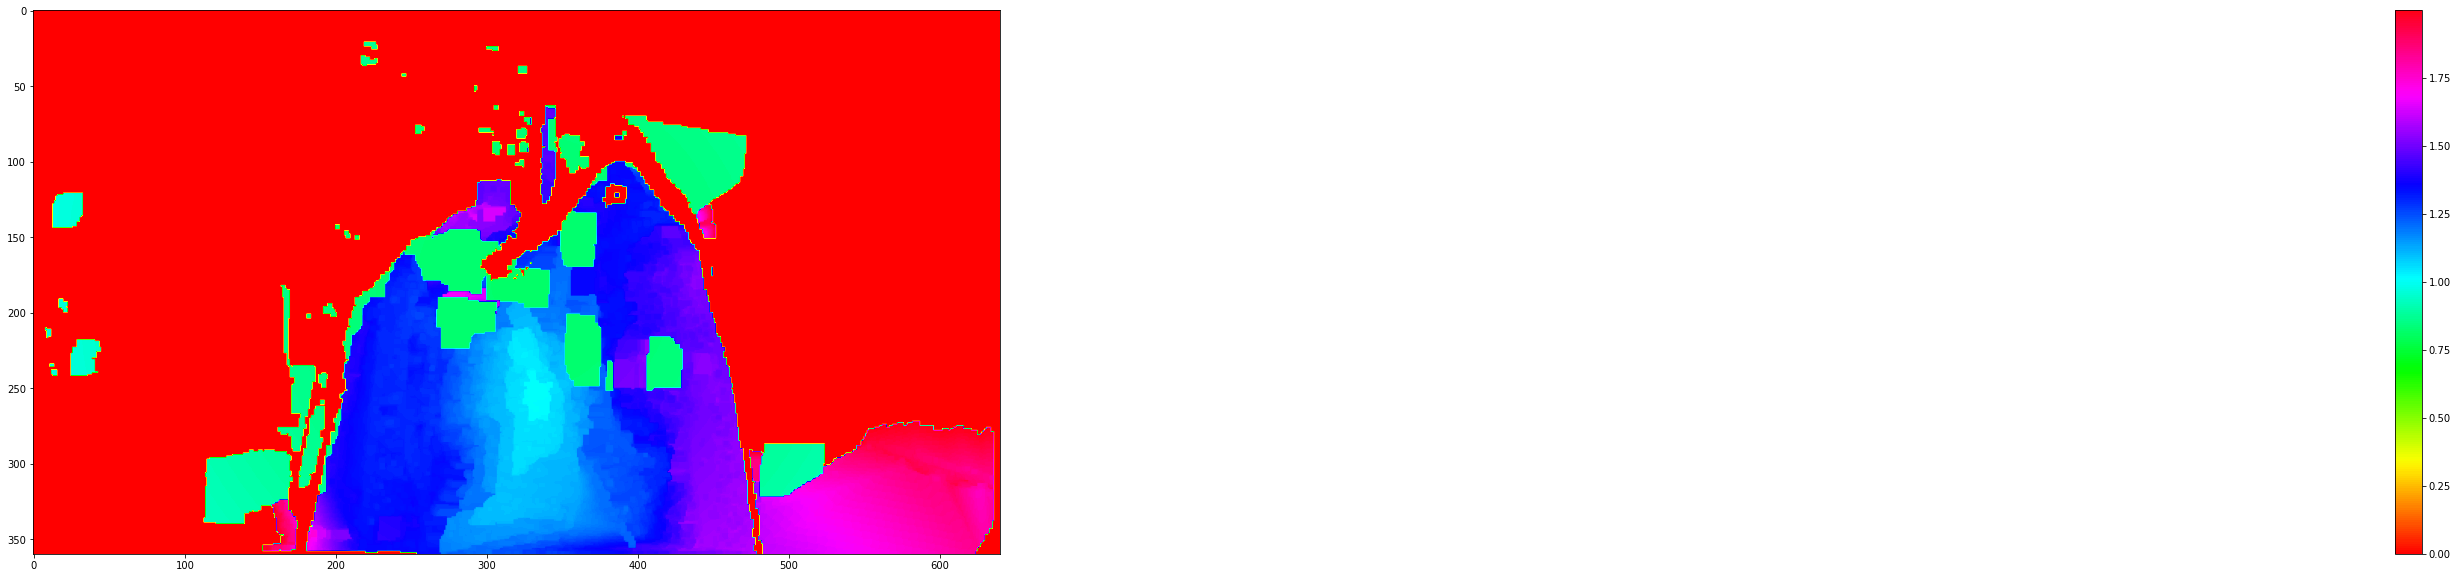

elas scale 1.1542151440612092 at range 0-2m
/media/pc/Data/bag-extractor/output//2022-01-27-15-10-42/smartphone_video_frames/left/2720739574037.png
/media/pc/Data/bag-extractor/output//2022-01-27-15-10-42/smartphone_video_frames/right/2720739593056.png


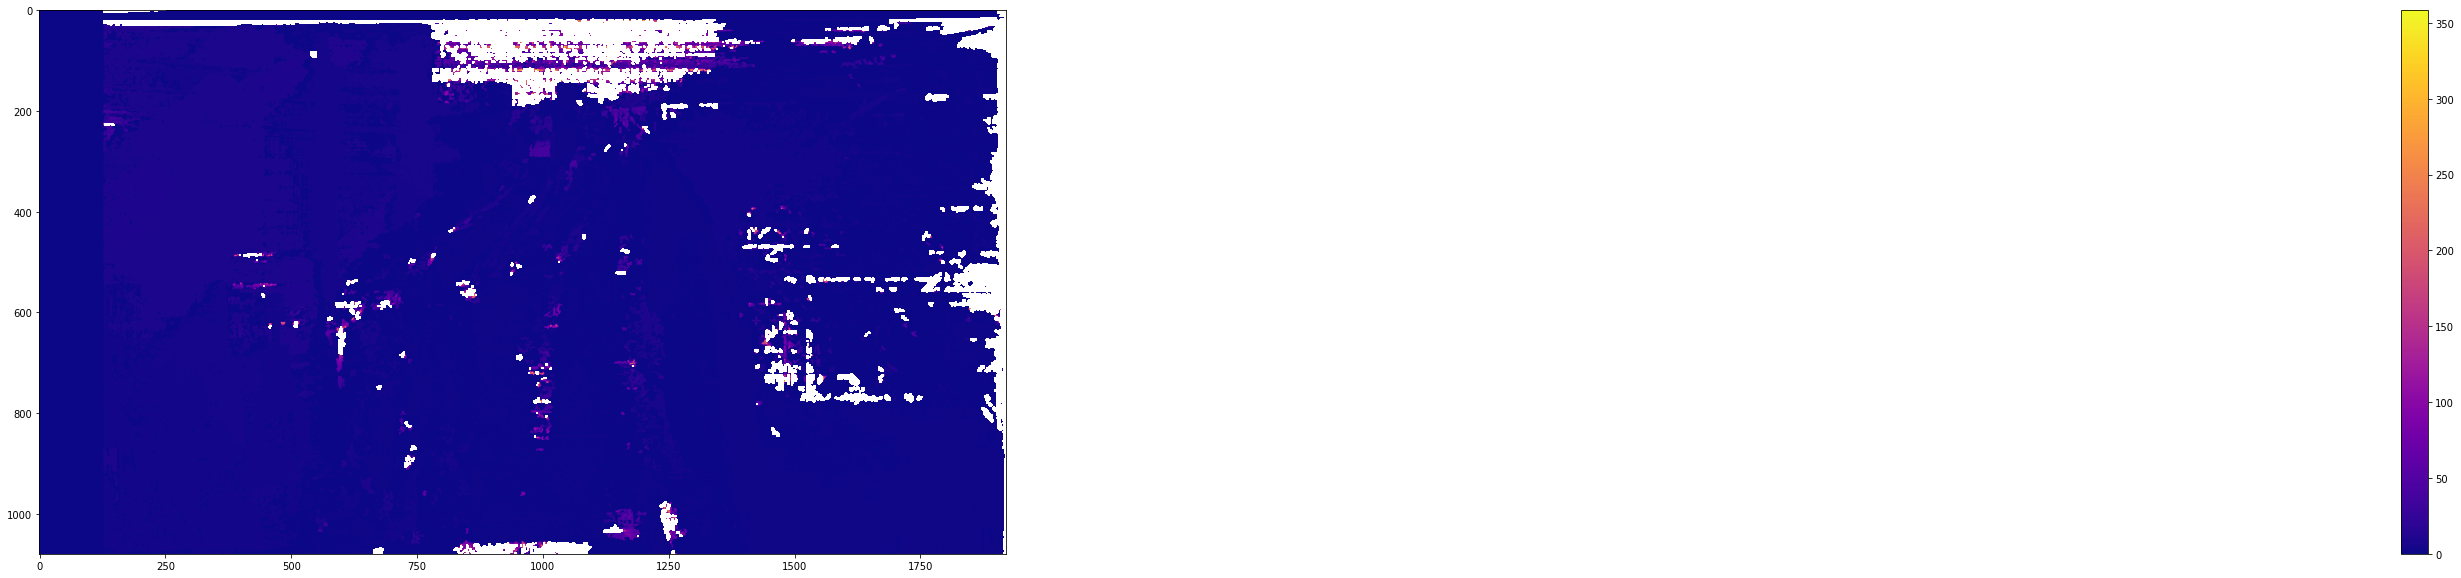

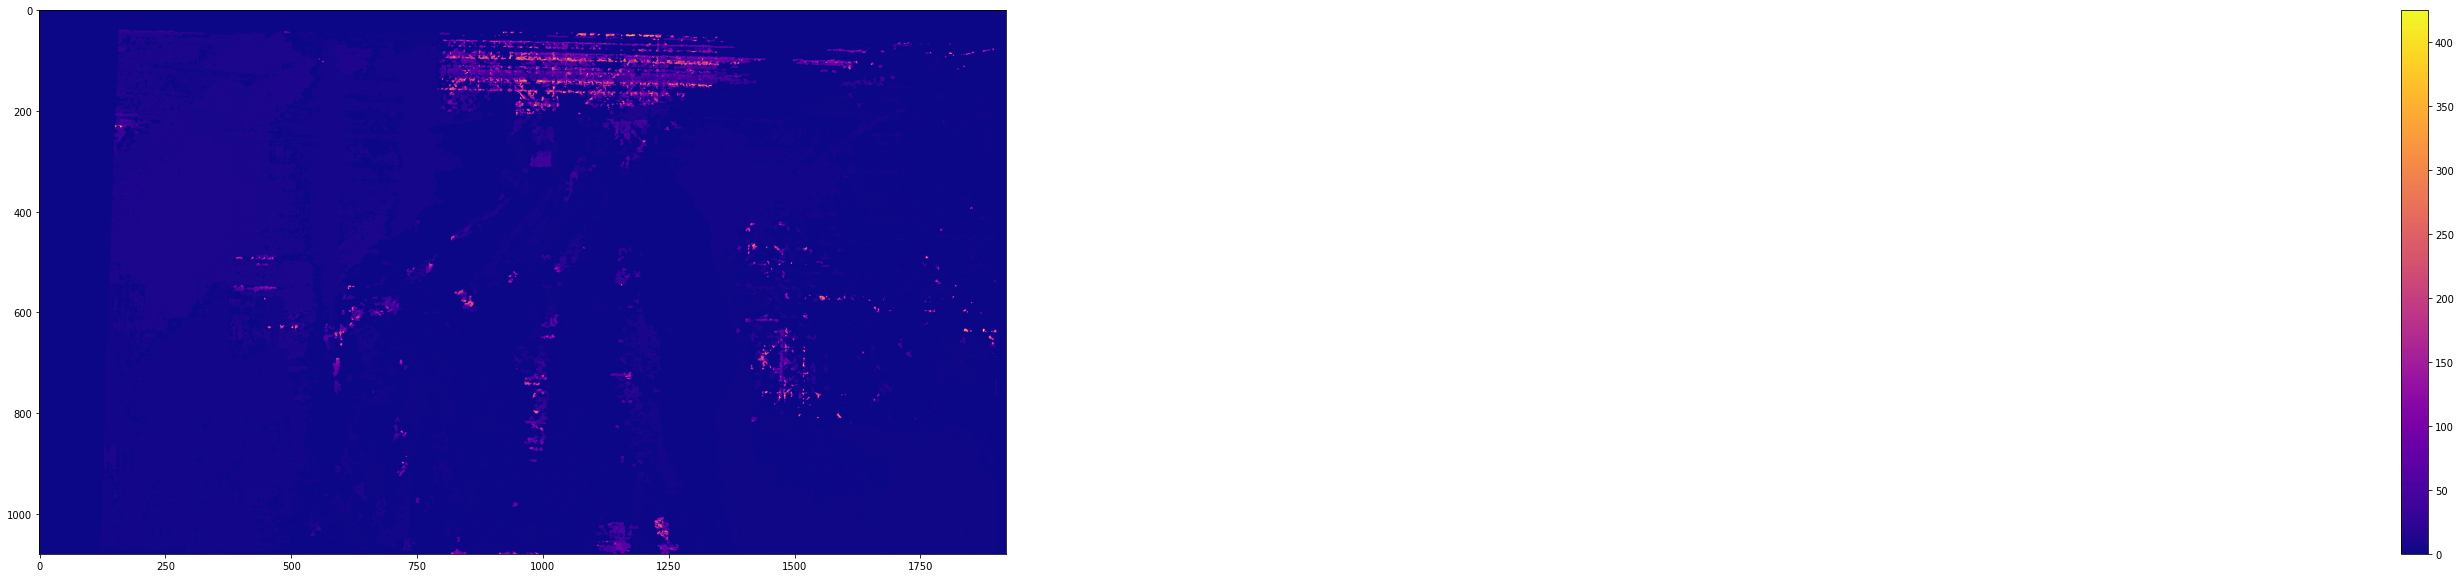

KeyboardInterrupt: 

In [170]:
counter = 0

left_img_ext = 'png'
if (with_arcore):
    left_img_ext = 'jpg'

stereo_azure_matches = []

with open(f'{path}/match.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        l_name = row[1]
        l_name = l_name[:4] + '.' + l_name[4:]

        if l_name in association:
            stereo_azure_matches.append((row[1], row[2], l_name))
stereo_azure_matches = stereo_azure_matches[10:]
            
def process_pair(stereo_azure_match):
    l_name = stereo_azure_match[2]
    print(f'{path}/left/{stereo_azure_match[0]}.{left_img_ext}')
    print(f'{path}/right/{stereo_azure_match[1]}.png')

    imgL = read_rotate(f'{path}/{left_dir_name}/{stereo_azure_match[0]}.{left_img_ext}', 1)
    imgR = read_rotate(f'{path}/right/{stereo_azure_match[1]}.png', 1)
    imgL_rect, imgR_rect = utils.rect(imgL, imgR, (x, y, w, h), (Left_Stereo_Map, Right_Stereo_Map), scaling)

    cv2.imwrite(f"l.png", imgL_rect)
    cv2.imwrite(f"r.png", imgR_rect)

    # ----------------- SGBM -----------------------
    dispSGBM_l = utils.depth_map_SGBM(imgL_rect, imgR_rect, 0, 128, block_size=3)
    depthSGBM_l = depth_from_disp((dispSGBM_l / 16.0).astype(np.float32), Q)   
    plt.figure(figsize = (500, 10))
    plt.imshow(depthSGBM_l, cmap='plasma')
    plt.colorbar()

    depthSGBM_l = _align_rgb_depth(imgL_rect, depthSGBM_l, (0, 0, 640, 360), inv(T1), undist_mtx_original, undist_mtx, distL)
    plt.figure(figsize = (500, 10))
    plt.imshow(depthSGBM_l, cmap='plasma')
    plt.colorbar()

    plt.show()
    # -------------- GT Depth ----------------------
    depthGT = cv2.imread(f'{gt_path}/{association[l_name][1]}.png', -1) / 5000.0
    depthGT_unaligned = cv2.imread(f'{gt_unaligned_path}/{association[l_name][1]}.png', -1) / 5000.0
    # ---------LibELAS------------------------------
    imgL_r_c = imgL_rect

    imgL_rect = cv2.cvtColor(imgL_rect, cv2.COLOR_BGR2GRAY)
    imgR_rect = cv2.cvtColor(imgR_rect, cv2.COLOR_BGR2GRAY)

    cv2.imwrite(f"l.pgm", imgL_rect)
    cv2.imwrite(f"r.pgm", imgR_rect)
    command = '../libelas/cmake-build-debug/elas l.pgm r.pgm'
    process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
    output, error = process.communicate()
    elas_disp = cv2.imread("l_disp.pgm", -1)


    depthELAS = depth_from_disp(elas_disp, Q)
    depthELAS = _align_rgb_depth(imgL_rect, depthELAS, (x, y, w, h), inv(T1), undist_mtx_original, undist_mtx, distL)

    # ARCore
    if with_arcore:
        for val in arcore_ts:

            if abs(val - int(stereo_azure_match[0])) < 15000000:
                timestamp_diffs.append(abs(int(stereo_azure_match[0]) - int(stereo_azure_match[1])))

                print(val)
                depthARC = np.fromfile(f'{path}/{left_dir_name}/{val}.txt', dtype = np.uint16) 
                depthMap = np.array([utils.extract_depth_arcore(x) for x in depthARC]).reshape(90,160).astype('float32') / 1000.0
                if depthMap.max() > 0:
                    width = 640
                    height = 360
                    dim = (width, height)

                    plt.figure(figsize = (500, 10))

                    depthMap = cv2.rotate(depthMap, cv2.ROTATE_180)

                    # ------------- Metrics ----------------------
                    eval_add_to_dict(depthGT_unaligned, depthSGBM_l, 'sgbm', '0-2m', 0, 2, errs_all)

                    eval_add_to_dict(depthGT_unaligned, depthELAS, 'elas', '0-2m', 0, 2, errs_all)
                    eval_add_to_dict(depthGT_unaligned, depthMap, 'arcore', '0-2m', 0, 2, errs_all)


    #                 errs_all = eval_add_to_dict(depthGT_unaligned, depthSGBM_l, 'sgbm', 'all', 2, 4, errs_all)

    #                 errs_all = eval_add_to_dict(depthGT_unaligned, depthELAS, 'elas', '2-4m', 2, 4, errs_all)
    #                 errs_all = eval_add_to_dict(depthGT_unaligned, depthMap, 'arcore', '2-4m', 2, 4, errs_all)

    #                 errs_all = eval_add_to_dict(depthGT_unaligned, depthSGBM_l, 'sgbm', 'all', 0, 10, errs_all)

    #                 errs_all = eval_add_to_dict(depthGT_unaligned, depthELAS, 'elas', 'all', 0, 10, errs_all)
    #                 errs_all = eval_add_to_dict(depthGT_unaligned, depthMap, 'arcore', 'all', 0, 10, errs_all)                 
                    print('Added metrics')    
    else:
        eval_add_to_dict(depthGT_unaligned, depthSGBM_l, 'sgbm', '0-2m', 0, 2, errs_all)
        eval_add_to_dict(depthGT_unaligned, depthELAS, 'elas', '0-2m', 0, 2, errs_all)

for row in stereo_azure_matches:
    process_pair(row)

## Generate depth for reconstruction

In [ ]:
import time
import shutil

# pairs (VID - interval for reconstruction)

fragments = {}

fragments['lab_ar'] = ('/2022-01-27-16-37-03', 426557268798, 100)
fragments['clothes_ar'] = ('/2022-01-27-15-14-29', 2943080227153, 400)
fragments['boxes_ar'] = ('/2022-01-27-18-04-36', 267802085459, 100)
dataset = 'boxes_ar'



VID = fragments[dataset][0]
path = f"/media/pc/Data/bag-extractor/output/{VID}/smartphone_video_frames"
gt_path = f"/media/pc/Data/bag-extractor/output/{VID}/depth"
gt_unaligned_path = f"/media/pc/Data/bag-extractor/output/{VID}/depth_unaligned"
root = "/media/pc/Data/"

arcore_ts = []
for file in glob.glob(f'{path}/left/*.txt'):
#     print(os.path.basename(file))     
    
    name = int(os.path.basename(file).split('.')[0])
#     print(name)
    arcore_ts.append(name)
    
#     depthARC = np.fromfile(f'{path}/left_ar/{row[1]}.txt', dtype = np.uint16) 
#     depthMap = np.array([extractDepth(x) for x in depthARC]).reshape(90,160)

# arcore_ts
#     plt.imshow(depthMap, cmap="hsv")
#     plt.colorbar()
#     plt.show()


# Prepare folder infrastructure
if os.path.exists(os.path.join(root, dataset)):
    shutil.rmtree(os.path.join(root, dataset))

folder = os.path.join(root, dataset)
os.mkdir(folder)

if os.path.exists(os.path.join(folder, 'image')):
    shutil.rmtree(os.path.join(folder, 'image'))

    
if os.path.exists(os.path.join(folder, 'depth')):
    shutil.rmtree(os.path.join(folder, 'depth'))

    
os.mkdir(os.path.join(folder, 'depth'))
os.mkdir(os.path.join(folder, 'image'))

def read_rotate(path, bw):
    if (bw == 0):
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path, 1)


    return cv2.rotate(img, cv2.ROTATE_180)

timestamp_diffs = []
count = 0
count_ = 0
with open(f'{path}/match.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        
        l_name = row[1]
        l_name = l_name[:3] + '.' + l_name[3:]
        print(row[1])
        
        if row[1] != 'left' and int(row[1]) >= fragments[dataset][1] and count_ <= fragments[dataset][2]:
            count += 1
            if count % 1 == 0:
                # Prepare input images
                count_ += 1

                print(f'{path}/left/{row[1]}.jpg')
                print(f'{path}/right/{row[2]}.png')

                imgL = read_rotate(f'{path}/left/{row[1]}.jpg', 1)
                imgR = read_rotate(f'{path}/right/{row[2]}.png', 1)

                imgL_rect, imgR_rect = utils.rect(imgL, imgR, (0, 60, 640, 360), (Left_Stereo_Map, Right_Stereo_Map))

    #             imgL_rect = cv2.resize(imgL_rect, (640, 360))
    #             imgR_rect = cv2.resize(imgR_rect, (640, 360))


                # ----------------- ARCORE -----------------------
                t = time.process_time()
                         # ARCore
                for val in arcore_ts:
                    if abs(val - int(row[1])) < 15000000:
                        timestamp_diffs.append(abs(int(row[1]) - int(row[2])))

                        print(val)
                        depthARC = np.fromfile(f'{path}/left/{val}.txt', dtype = np.uint16) 
                        depthMap = np.array([utils.extract_depth_arcore(x) for x in depthARC]).reshape(90,160).astype('float32') / 1000.0
       
                        if depthMap.max() > 0:
                            width = 640
                            height = 360
                            dim = (width, height)

                            # resize image
                            depthMap = cv2.resize(depthMap, dim)

    #                         tmp = np.zeros((640, 360))
    #                         tmp = depthMap[60:-60, :]
    #                         depthMap = tmp

        #                     depthMap = cv2.cvtColor(depthMap, cv2.COLOR_BGR2GRAY)
#                             plt.figure(figsize = (500, 10))

#                             plt.imshow(cv2.rotate(depthMap, cv2.ROTATE_180), cmap="plasma")
#                             plt.colorbar()
#                             plt.show()
                            depthMap = cv2.rotate(depthMap, cv2.ROTATE_180)


                            tmp = np.zeros((640, 360, 3))
                            tmp = imgL[60:-60, :, :]
                            crop_img = tmp
                            crop_depth = depthMap[:, :]

                            cv2.imwrite(f"/media/pc/Data/{dataset}/image/image{count_:05}.png", crop_img)
                            cv2.imwrite(f"/media/pc/Data/{dataset}/depth/depth{count_:05}.png", (crop_depth*1000).astype(np.uint16))


In [ ]:
low = 5
high = len(errs_all["all"]['arcore']['errs'])  - 5
high


## Present metrics results

In [768]:
comp_range = 'all'

In [52]:
res_arcore = pd.DataFrame(errs_all[comp_range]['arcore']['errs'][low:high])
res_arcore.head()
print(res_arcore[['num_valid', 'l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
       'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125']].mean(axis=0))
print('VARIANCE:')
print(res_arcore[['l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
       'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125']].var(axis=0))
res_arcore.drop(columns=['num_valid', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125',  'abs_relative',
       'sq_relative', 'l1_inverse']).plot()

NameError: name 'pd' is not defined

In [770]:
res_arcore.columns

Index(['num_valid', 'l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
       'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125'],
      dtype='object')

In [771]:
res = []

for dist_range in ['0-2m', '2-4m', 'all']:
    for method in ['arcore', 'sgbm', 'elas']:
#         errs_all[dist_range][method]['errs']['name'] = f'{method}_{dist_range}'
        if method in errs_all[dist_range]:
            errs_mean = pd.DataFrame(errs_all[dist_range][method]['errs']).mean(axis=0)
            errs_mean['name'] = f'{method}_{dist_range}'
            res.append(errs_mean)
res_df = pd.DataFrame(res, columns=['name', 'num_valid','l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
           'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
           'ratio_threshold_1.5625', 'ratio_threshold_1.953125'])

res_df.to_excel(f"{VID[1:]}.xlsx",
             sheet_name=f'{VID[1:]}')

res = []

for dist_range in ['0-2m', '2-4m', 'all']:
    for method in ['arcore', 'sgbm', 'elas']:
#         errs_all[dist_range][method]['errs']['name'] = f'{method}_{dist_range}'
        if method in errs_all[dist_range]:
            errs_var = pd.DataFrame(errs_all[dist_range][method]['errs']).var(axis=0)
            errs_var['name'] = f'{method}_{dist_range}'
            res.append(errs_var)
res_df = pd.DataFrame(res, columns=['name', 'num_valid','l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
           'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
           'ratio_threshold_1.5625', 'ratio_threshold_1.953125'])

res_df.to_excel(f"{VID[1:]}_var.xlsx",
             sheet_name=f'{VID[1:]}_var')

num_valid                   71324.350000
l1                              0.335516
l1_inverse                      0.074663
scale_invariant                 0.204430
abs_relative                    0.129057
sq_relative                     0.145982
avg_log10                       0.062693
rmse_log                        0.237434
rmse                            0.555981
ratio_threshold_1.25            0.853193
ratio_threshold_1.5625          0.951768
ratio_threshold_1.953125        0.968199
dtype: float64
VARIANCE:
l1                          0.014369
l1_inverse                  0.006120
scale_invariant             0.015209
abs_relative                0.002509
sq_relative                 0.016864
avg_log10                   0.001361
rmse_log                    0.021000
rmse                        0.049200
ratio_threshold_1.25        0.005227
ratio_threshold_1.5625      0.004040
ratio_threshold_1.953125    0.003608
dtype: float64


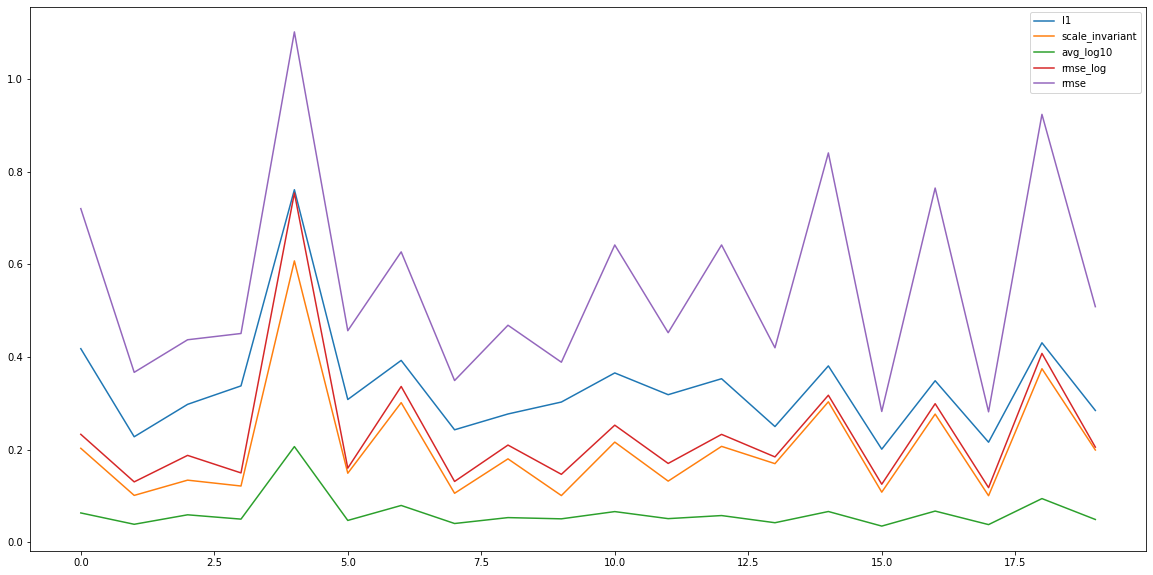

In [772]:
res_sgbm = pd.DataFrame(errs_all[comp_range]['sgbm']['errs'][low:high])
res_sgbm.head()

print(res_sgbm[['num_valid', 'l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
       'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125']].mean(axis=0))

print('VARIANCE:')
print(res_sgbm[['l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
       'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125']].var(axis=0))

res_sgbm.drop(columns=['num_valid', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125',  'abs_relative',
       'sq_relative', 'l1_inverse']).plot()

num_valid               134673.452381
l1                           0.563697
l1_inverse                   0.246089
scale_invariant              0.524102
abs_relative                 0.239040
sq_relative                  0.568113
avg_log10                    0.117728
rmse_log                     0.544734
rmse                         1.053008
ratio_threshold_1.25         0.771447
dtype: float64
l1                          0.064076
l1_inverse                  0.026791
scale_invariant             0.033943
abs_relative                0.017087
sq_relative                 0.295303
avg_log10                   0.002941
rmse_log                    0.038883
rmse                        0.187502
ratio_threshold_1.25        0.011939
ratio_threshold_1.5625      0.008118
ratio_threshold_1.953125    0.005670
dtype: float64


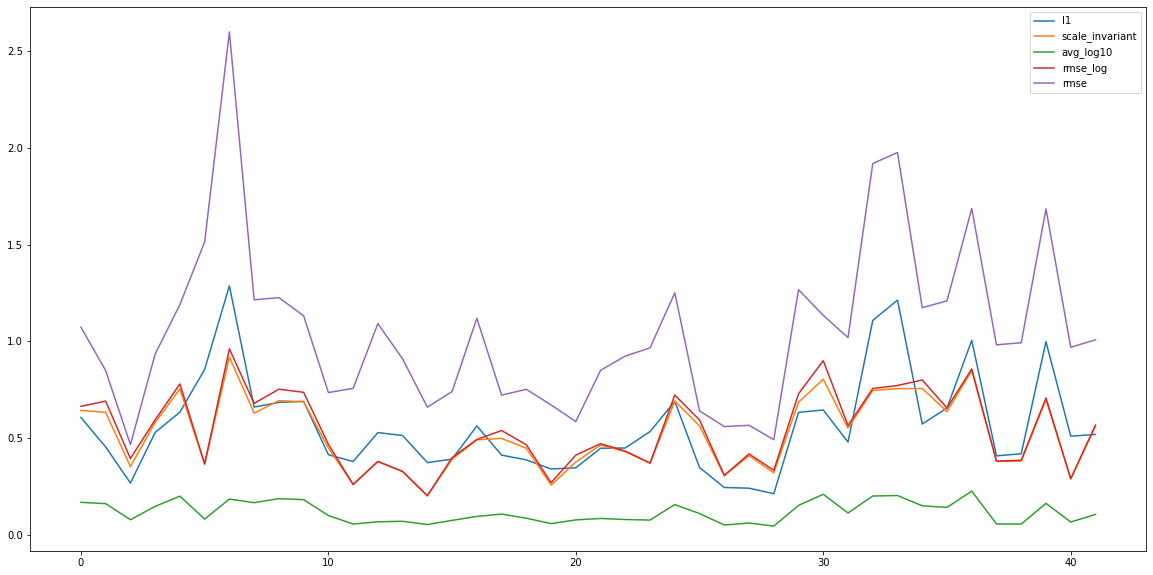

In [760]:
res_elas = pd.DataFrame(errs_all[comp_range]['elas']['errs'][low:high])
res_elas.head()
# res_elas['t_diffs'] = 50*(np.array(timestamp_diffs) / np.array(timestamp_diffs).max() - np.array(timestamp_diffs).min()/np.array(timestamp_diffs).max())

print(res_elas[['num_valid', 'l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
       'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25']].mean(axis=0))


print(res_elas[['l1', 'l1_inverse', 'scale_invariant', 'abs_relative',
       'sq_relative', 'avg_log10', 'rmse_log', 'rmse', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125']].var(axis=0))

res_elas.drop(columns=['num_valid', 'ratio_threshold_1.25',
       'ratio_threshold_1.5625', 'ratio_threshold_1.953125',  'abs_relative',
       'sq_relative', 'l1_inverse']).plot()



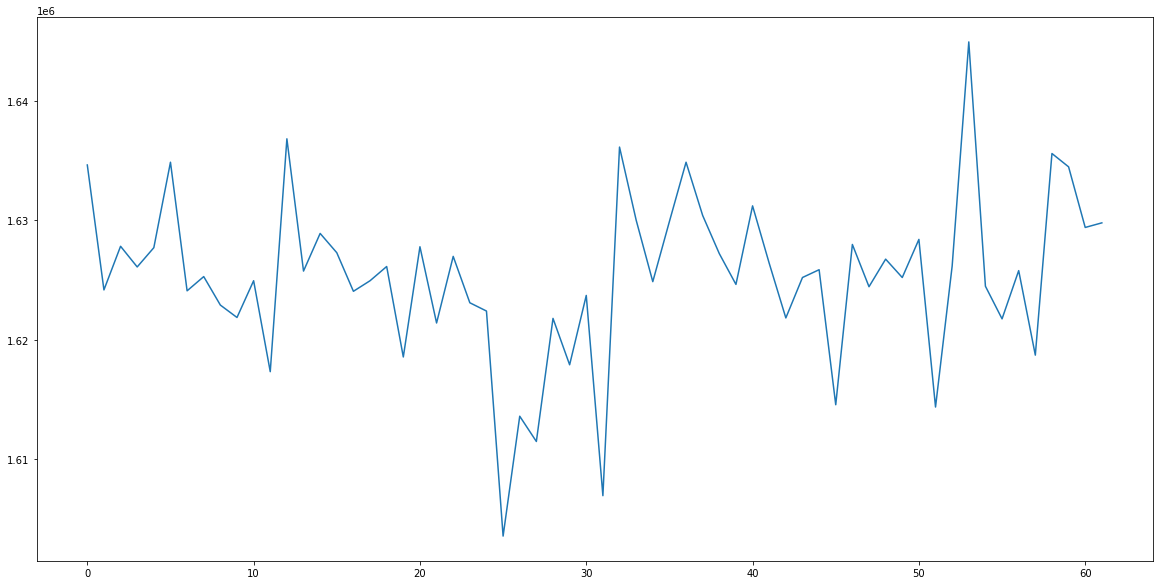

In [752]:
plt.plot(timestamp_diffs)

## Older versions

In [14]:
import subprocess

In [16]:
command = 'python3 ./single_inference/inference.py --ckpt "ckpt/pydnet" --img "test"'
process = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
output, error = process.communicate()